In [121]:
import jax
import jax_metrics as jm
import jax.numpy as jnp
from jax import grad, jit, vmap
from functools import partial
from jax import random
import os
import numpy as np
import matplotlib.pyplot as plt
# Switch off the cache 
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

# Basic Linear Model

Class for Linear estimation with Canonical and Gradient Descent

In [122]:
class Linear_Model():
    """
    Basic Linear Regression with Ridge Regression
    """
    def __init__(self, dim: int) -> None:
        self.dim = dim
        self.key = random.PRNGKey(0)
        self.cpus = jax.devices("cpu")
    
    # The classic one
    def generate_canonical_estimator(self, X: jnp, y:jnp) -> jnp:
        """
        Cannonical LSE error solution for the Linearly separable classes 
        args:
            X: Data array at the GPU or CPU
            y: Label array at the GPU 
        returns:
            w: Weight array at the GPU or CPU
        """
        return  jax.numpy.linalg.inv(jax.numpy.transpose(X)@X)@jax.numpy.transpose(X)@y
    
    @staticmethod
    @jit
    def linear_model(X: jnp, theta: jnp) -> jnp:
        """
        Classic Linear Model. Jit has been used to accelerate the loops after the first one
        for the Gradient Descent part
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
        returns:
            f(x): the escalar estimation on vector x or the array of estimations
        """
        w = theta[:-1]
        b = theta[-1]

        
        
        return jax.numpy.matmul(X, w) + b
    
    @partial(jit, static_argnums=(0,))
    def LSE(self, theta: jnp, X: jnp, y: jnp)-> jnp:
        """
        LSE in matrix form. We also use Jit por froze info at self to follow 
        the idea of functional programming on Jit for no side effects
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
            y: array of labels
        returns:
            the Loss function LSE under data X, labels y and theta initial estimation
        """
        return (jax.numpy.transpose(y - self.linear_model(X, theta))@(y - self.linear_model(X, theta)))[0,0]

        #(jax.numpy.transpose(y - jax.numpy.matmul(X, w) + b)@(y - jax.numpy.matmul(X, w) + b))[0,0]
    
    @partial(jit, static_argnums=(0,))
    def update(self, theta: jnp, X: jnp, y: jnp, lr):
        """
        Update makes use of the autograd at Jax to calculate the gradient descent.
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
            y: array of labels
            lr: Learning rate for Gradient Descent
        returns:
            the step update w(n+1) = w(n)-δ(t)𝜵L(w(n))        
        """
        return theta - lr * jax.grad(self.LSE)(theta, X, y)

    

    def generate_w_aug(self):
        """
        Use the random generator at Jax to generate a random generator to instanciate
        the augmented values
        """
        keys = random.split(self.key, 1)
        return jax.numpy.vstack([random.normal(keys, (self.dim,1)), jax.numpy.array(1)])
    
    def generate_theta(self):
        """
        Use the random generator at Jax to generate a random generator to instanciate
        the augmented values
        """
        keys = random.split(self.key, 1)
        return jax.numpy.vstack([random.normal(keys[0], (self.dim,1)), jax.numpy.array(0)])
        #return jax.numpy.vstack([random.normal(keys), jax.numpy.array(0)])
    
    @partial(jit, static_argnums=(0,))
    def estimate_grsl(self, X, theta):
        """
        Estimation for the Gradient Descent version
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
        return:
            Estimation of data X under linear model
        """
        w = theta[:-1]
        b = theta[-1]
        return X@w+b
    
    @staticmethod
    def estimate_cannonical(X: jnp, w: jnp)->jnp:
        """
        Estimation for the Gradient Descent version
        args:
            X: Data array at the GPU or CPU
            w: Parameter w under extended space
        return:
            Estimation of data X under cannonical solution
        """
        return X@w
    
    def precision(self, y, y_hat):
        """
        Precision
        args:
            y: Real Labels
            y_hat: estimated labels
        return TP/(TP+FP)
        """
        TP=0
        FP=0
        for i in range(len(y)):
            if(y_hat[i]>0 and y[i]>0) :
                TP+=1
            if(y_hat[i]>0 and y[i]<0):
                FP+=1
            

        #TP = sum(y_hat[y>0]>0)
        #FP = sum(y_hat[y>0]<0)
        precision_cpu = jax.jit(lambda x: x, device=self.cpus[0])(TP/(TP+FP))
        return float(precision_cpu)
    
    def accuracy(self, y, y_hat):
        """
        Precision
        args:
            y: Real Labels
            y_hat: estimated labels
        return TP/(TP+FP)
        """
        TP=0
        TN=0
        FP=0
        FN=0
        for i in range(len(y)):
            if(y_hat[i]>0 and y[i]>0) :
                TP+=1
            if(y_hat[i]<0 and y[i]<0):
                TN+=1
            if(y_hat[i]<0 and y[i]>0):
                FP+=1
            if(y_hat[i]>0 and y[i]<0):
                FN+=1

        #TP = sum(y_hat[y>0]>0)
        #FP = sum(y_hat[y>0]<0)
        accuracy_cpu = jax.jit(lambda x: x, device=self.cpus[0])((TP+TN)/(TP+FP+TN+FN))
        return float(accuracy_cpu)
    
    def gradient_descent(self, theta: jnp,  X: jnp, y: jnp, n_steps: int, lr = 0.001):
        """
        Gradient Descent Loop for the LSE Linear Model
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
            y: array of labels
            n_steps: number steps for the Gradient Loop
            lr: Learning rate for Gradient Descent   
        return:
            Updated Theta
        """
        for i in range(n_steps):
            theta = self.update(theta, X, y, lr)
        return theta
    
    
    #algoritmo para el golden ratio

    def update_golden(self, theta: jnp, X: jnp, y: jnp,a:int,c:int, MaxSteps:int, epsilon:float):
        
        error=jax.grad(self.LSE)(theta, X, y)
        print("este es el error",error)
        theta_minimizado=self.min(a,c, theta, error,X,y,MaxSteps,epsilon)
        return theta_minimizado
        '''
       ####este era otro intento de golden ratio que por alguna razón no funcionó 
    def golden_ratio(self,y,theta,X,x1,x3, error):
        print(theta)

        def j(lr):
            #error=jax.grad(self.LSE)(theta, X, y)
            theta2=theta - lr *  error
            
            j=self.LSE(theta2,X,y)
            #j=(jax.numpy.transpose(y - self.linear_model(X, theta2))@(y - self.linear_model(X, theta2)))[0,0]

            #=(jax.numpy.transpose(y - self.linear_model(X, theta))@(y - self.linear_model(X, theta)))[0,0]
            
            return j
        phi=1.618
        ep=1e-5
        x2=x1+(x3-x1)/(1+phi)
        x4=x2+(x3-x2)/(1+phi)
        j_2=j(x2)
        j_4=j(x4)
       # print(x2,x4)
        i=0
        while abs(x3-x1)>ep:
            
            if j_2<j_4:
                x3=x4
                
                x2=x1+(x3-x1)/(1+phi)
                x4=x2+(x3-x2)/(1+phi)
                print('if',x2,j(x2))
            else:
                x1=x2
                
                x2=x1+(x3-x1)/(1+phi)
                x4=x2+(x3-x2)/(1+phi)
                print('else',x2,j(x2))
            i=i+1   
        lr=(x3-x1)/2
        print(j(lr),lr,i)
        return lr
    
    def lr_update(self,theta, X, y,lr, error):
            x1=-1
            x3=1
            lr=self.golden_ratio(y,theta,X,x1,x3,error)
            theta=self.update(theta, X, y,lr)
            print(theta)
            return lr

    def gradient_descent_lr(self, theta: jnp,  X: jnp, y: jnp, n_steps: int, lr):
        
        
        #theta=self.update(theta, X, y,lr)
        error=jax.grad(self.LSE)(theta, X, y)
        print("este es el erro", error, "este es theta", theta, "este es x",y)
        lr=self.lr_update(theta, X, y,lr,error)
        
        #print(theta[0],lr)
        return theta

    @partial(jit, static_argnums=(0,))
    def estimate_grsl(self, X, theta):
        """
        Estimation for the Gradient Descent version
        args:
            X: Data array at the GPU or CPU
            theta: Parameter w for weights and b for bias
        return:
            Estimation of data X under linear model
        """
        w = theta[:-1]
        b = theta[-1]
        return X@w+b
      '''
    def golden_iniciales(self,a:int,c:int):
        phi=1.618
        b=a + (c-a)/(1+phi)
        d=b+(c-b)/(1+phi)
        return b,d

    def min(self,a,c, theta: jnp, error,X: jnp,y: jnp, MaxSteps:int, epsilon:float):
        
        phi=1.618
        Step=0
        print(" error",error)

        def theta2(lr, theta, error):
            theta2= theta - lr * error
            return theta2

        b,d=self.golden_iniciales(a,c)
        
        f_a=self.LSE(theta2(a, theta, error), X, y)
        f_c=self.LSE(theta2(c, theta, error), X, y)
        
        while abs(a-c)>epsilon and Step < MaxSteps:
            f_d=self.LSE(theta2(d, theta, error), X, y)
            f_b=self.LSE(theta2(b, theta, error), X, y)
            if f_b<f_d:
                c=d
                f_c=f_d
                b=a + (c-a)/(1+phi)
                d=b+(c-b)/(1+phi)
                print(b, f_b)
            else:
                a=b
                f_a=f_b
                b=a + (c-a)/(1+phi)
                d=b+(c-b)/(1+phi)
                print(b, f_b)
            Step +=1

        print("se necesitaron estos pasos:", Step)
        theta_min=theta2(b, theta, error)
        return theta_min

    ####################################################################################################
    #############################vamos a hacer el método de bisección#####################################
    def gradient_descent_biseccion(self, theta: jnp,  X: jnp, y: jnp, n_steps: int, a, b):
        for i in range(n_steps):
            c = a + b / 2
            theta = self.update(theta, X, y, c)
            b = c
            print(f"lr: {c}")
        return theta
    ######################################################################################################
    #########vamos a hacer la implementación de la regularización de Ridge##################################

    def generate_canonicalRidge_estimator(self, X: jnp, y:jnp,la:jnp) -> jnp:
        """
        Cannonical LSE error solution for the Linearly separable classes 
        args:
            X: Data array at the GPU or CPU
            y: Label array at the GPU 
        returns:
            w: Weight array at the GPU or CPU
        """
        XX=jax.numpy.transpose(X)@X
        dimension=int(jnp.shape(XX)[0])
        I=jax.numpy.identity(dimension)
        return  jax.numpy.linalg.inv(XX+la*I)@jax.numpy.transpose(X)@y
    
    @staticmethod
    def estimate_cannonicalRidge(X: jnp, w: jnp)->jnp:
        """
        Estimation for the Gradient Descent version
        args:
            X: Data array at the GPU or CPU
            w: Parameter w under extended space
        return:
            Estimation of data X under cannonical solution
        """
        return X@w
    

# Generate Data

In [123]:
X1 = np.random.normal(size=(100,2))
X2 = np.random.normal(size=(100,2))+(5,5)

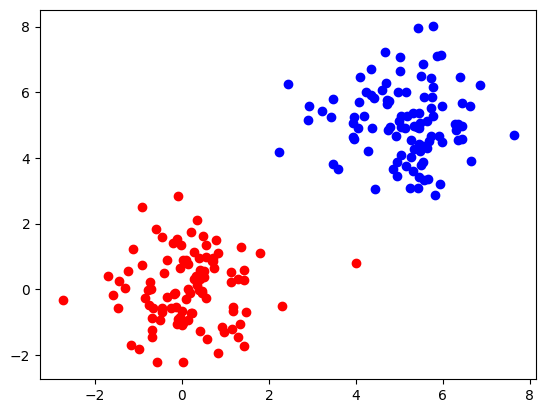

In [124]:
plt.figure()
plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')

# Expriments
Data Augmentation is applied for the Cannonical version

In [125]:
X1_e = np.hstack([X1, np.ones((100,1))])
X2_e = np.hstack([X2, np.ones((100,1))])

In [126]:
X_e = np.vstack([X1_e, X2_e])
X = np.vstack([X1, X2]) #va a tener todos los datos de X1 y X2 en un solo vector


In [127]:
y = np.vstack([-np.ones((100, 1)), np.ones((100, 1))])

In [128]:
model=Linear_Model(2)

Vamos a llamar al modelo de bisección


In [129]:
theta= model.generate_theta()
a=0
b=0.01
theta = model.gradient_descent_biseccion(theta, X, y, 20, a, b)

lr: 0.005
lr: 0.0025
lr: 0.00125
lr: 0.000625
lr: 0.0003125
lr: 0.00015625
lr: 7.8125e-05
lr: 3.90625e-05
lr: 1.953125e-05
lr: 9.765625e-06
lr: 4.8828125e-06
lr: 2.44140625e-06
lr: 1.220703125e-06
lr: 6.103515625e-07
lr: 3.0517578125e-07
lr: 1.52587890625e-07
lr: 7.62939453125e-08
lr: 3.814697265625e-08
lr: 1.9073486328125e-08
lr: 9.5367431640625e-09


Ahora vamos a realizar la estimación y ver qué recall obtenemos

In [130]:
y_hat = model.estimate_grsl(X, theta)
recall=model.precision(y, y_hat)
recall

0.6410256624221802

Vamos a hacer el modelo de Ridge probando para varios valores de lambda

1.0 0.2
0.9900990128517151 0.4
0.9900990128517151 0.6000000000000001
0.9900990128517151 0.8
0.9900990128517151 1.0
0.9900990128517151 1.2
0.9900990128517151 1.4
0.9900990128517151 1.5999999999999999
0.9900990128517151 1.7999999999999998
0.9900990128517151 1.9999999999999998
0.9900990128517151 2.1999999999999997
0.9900990128517151 2.4
0.9900990128517151 2.6
0.9900990128517151 2.8000000000000003
0.9900990128517151 3.0000000000000004
0.9900990128517151 3.2000000000000006
0.9900990128517151 3.400000000000001
0.9900990128517151 3.600000000000001
0.9900990128517151 3.800000000000001
0.9900990128517151 4.000000000000001


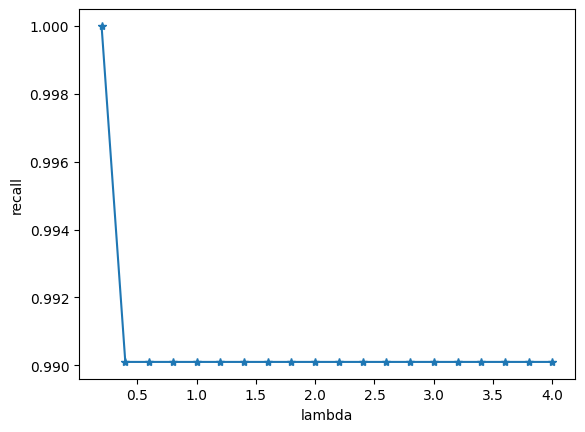

In [131]:
#vamos a buscar lambda en un grid de puntos[0,0.5,1,...]
l=0
max_steps=20
l_vec=np.zeros(int(max_steps))
precision=np.zeros(int(max_steps))
for i in range(max_steps):
    l=l+0.2
    l_vec[i]=l
    wR = model.generate_canonicalRidge_estimator(X_e, y,l)
    y_hatR = model.estimate_cannonicalRidge(X_e, wR)
    precision[i]=model.precision(y, y_hatR)
    print(precision[i],l
    )

w = model.generate_canonical_estimator(X_e, y)
y_hat = model.estimate_cannonical(X_e, w)

plt.plot(l_vec,precision,'*-')
plt.xlabel('lambda')
plt.ylabel('recall')
plt.show()

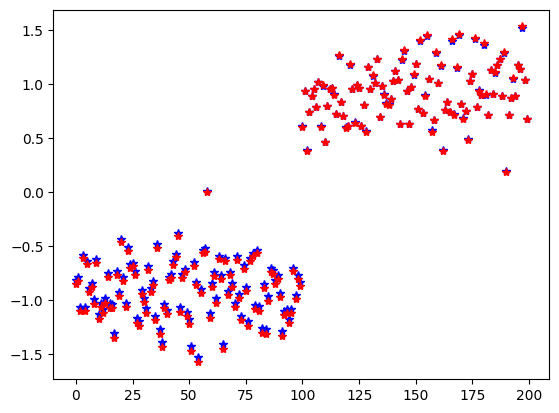

In [132]:
#veamos cómo cambian las predicciónes para el canónico (estrellas rojas) y con el último valor de lambda (estrellas azules)
plt.plot(y_hatR,'*b')
plt.plot(y_hat,'*r')
plt.show()

In [133]:
theta = model.generate_theta()
print(theta)

[[1.4321449]
 [1.3629805]
 [0.       ]]


In [134]:
theta = model.update_golden(theta, X, y,a=-1,c=1, MaxSteps=100, epsilon=0.00001)

este es el error [[14097.997 ]
 [14122.288 ]
 [ 2895.7656]]
 error [[14097.997 ]
 [14122.288 ]
 [ 2895.7656]]
0.2360802366644274 124891770000.0
0.055742348897221905 124723225000.0
-0.0557137005982033 6936131600.0
0.05574434861670731 6974294500.0
0.013171845327657764 6936628700.0
-0.01313966964280499 383220770.0
0.0131723174029683 392022430.0
0.0031221939445204086 383248420.0
-0.003089185546992083 20580526.0
0.0031223053877005398 22646762.0
0.000749765045304818 20582038.0
-0.0007165600686573847 972640.56
0.0007497913537817076 1459774.0
0.00018970393798348184 972718.44
-0.00015645255475283738 21983.666
0.00018971014864577125 136945.53
5.7489883417837694e-05 21986.416
-2.4227544949551017e-05 2544.6472
5.749134957364123e-05 29681.785
0.00010799599867162636 2544.4272
8.87052488784869e-05 728.307
7.678279159361784e-05 73.46625
8.87054627885461e-05 502.1729
8.415148070976738e-05 73.46427
8.870554449507293e-05 162.0615
9.152008811792411e-05 73.46351
se necesitaron estos pasos: 26


In [135]:
print(theta)
y_hat = model.estimate_grsl(X, theta)
model.precision(y, y_hat)

[[ 0.14189494]
 [ 0.07050741]
 [-0.26502073]]


0.9615384340286255

In [136]:
w = model.generate_canonical_estimator(X_e, y)
y_hat = model.estimate_cannonical(X_e, w)   #multiplica X y w
theta = model.generate_theta()
theta = model.gradient_descent(theta, X, y, 100, lr = 0.0001)
print(theta)

[[ 0.191542  ]
 [ 0.15854096]
 [-0.8600858 ]]


In [137]:
model.precision(y, y_hat)

1.0

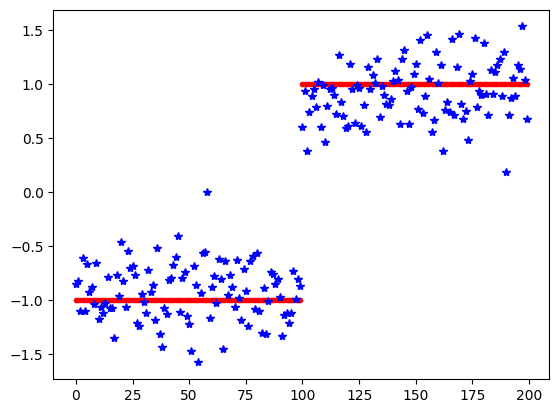

In [138]:
#y por último veamos qué tanto difieren nuestras predicciones (estrellas azules) de los valores verdaderos de las clases (linea roja)
plt.plot(y,'.r')
plt.plot(y_hat,'*b')

plt.show()